In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_val_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow_probability as tfp
import tf_keras

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_probability as tfp
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Required Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

In [40]:
# Load data
df = pd.read_excel('reordered_final_merged_cleaned_qqm_molecule_charges.xlsx')

# Filter for Tri_Q4 subset
tri_q4_df = df[df['_Alkene_Type'] == 'Tri_Q4']

# Prepare features and target
X = tri_q4_df.drop(columns=['Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])
X = X.loc[:, ~X.columns.str.contains('Q4')]  # Drop features containing 'Q4'
y = tri_q4_df['ddG']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

(576, 21)


MC dropout model: Bayesian-like

In [14]:
def build_mc_dropout_model(input_dim, dropout_rate=0.1):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(dropout_rate)(x, training=True)  
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x, training=True)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = X_train_scaled.shape[1]
model = build_mc_dropout_model(input_dim, dropout_rate=0.1)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_scaled, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2,
    verbose=0
)

def predict_with_uncertainty(model, x, n_iter=100):
    preds = np.zeros((n_iter, len(x)))
    for i in range(n_iter):
        preds[i] = model.predict(x, verbose=0).flatten()
    pred_mean = preds.mean(axis=0)
    pred_std = preds.std(axis=0)
    return pred_mean, pred_std

# Predict on training data
train_pred_mean, train_pred_std = predict_with_uncertainty(model, X_train_scaled, n_iter=100)

# Predict on test data
test_pred_mean, test_pred_std = predict_with_uncertainty(model, X_test_scaled, n_iter=100)

# Training metrics
mae_train = mean_absolute_error(y_train, train_pred_mean)
r2_train = r2_score(y_train, train_pred_mean)
print(f"Train R²: {r2_train:.4f}, MAE: {mae_train:.4f}")

# Test metrics
mae_test = mean_absolute_error(y_test, test_pred_mean)
r2_test = r2_score(y_test, test_pred_mean)
print(f"Test R²: {r2_test:.4f}, MAE: {mae_test:.4f}")



Train R²: 0.4598, MAE: 0.5724
Test R²: 0.3832, MAE: 0.6052


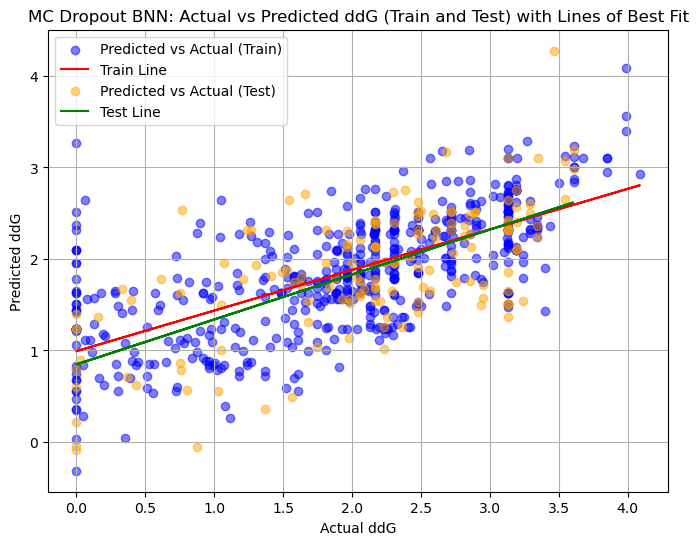

In [15]:
# Compute lines of best fit
slope_train, intercept_train = np.polyfit(y_train, train_pred_mean, 1)
slope_test, intercept_test = np.polyfit(y_test, test_pred_mean, 1)

# Plotting both train and test predictions
plt.figure(figsize=(8, 6))

# Training data
plt.scatter(y_train, train_pred_mean, color='blue', alpha=0.5, label='Predicted vs Actual (Train)')
plt.plot(y_train, slope_train * y_train + intercept_train, color='red', label=f'Train Line')

# Test data
plt.scatter(y_test, test_pred_mean, color='orange', alpha=0.5, label='Predicted vs Actual (Test)')
plt.plot(y_test, slope_test * y_test + intercept_test, color='green', label=f'Test Line')

plt.xlabel('Actual ddG')
plt.ylabel('Predicted ddG')
plt.title('MC Dropout BNN: Actual vs Predicted ddG (Train and Test) with Lines of Best Fit')
plt.legend()
plt.grid(True)
plt.show()


Epoch 10/1000, Loss: 1.0966
Epoch 20/1000, Loss: 1.2679
Epoch 30/1000, Loss: 1.0191
Epoch 40/1000, Loss: 0.8864
Epoch 50/1000, Loss: 0.8413
Epoch 60/1000, Loss: 0.8093
Epoch 70/1000, Loss: 0.7795
Epoch 80/1000, Loss: 0.7637
Epoch 90/1000, Loss: 0.7538
Epoch 100/1000, Loss: 0.7459
Epoch 110/1000, Loss: 0.7397
Epoch 120/1000, Loss: 0.7349
Epoch 130/1000, Loss: 0.7304
Epoch 140/1000, Loss: 0.7235
Epoch 150/1000, Loss: 0.7176
Epoch 160/1000, Loss: 0.7126
Epoch 170/1000, Loss: 0.7075
Epoch 180/1000, Loss: 0.7021
Epoch 190/1000, Loss: 0.6960
Epoch 200/1000, Loss: 0.6891
Epoch 210/1000, Loss: 0.6814
Epoch 220/1000, Loss: 0.6732
Epoch 230/1000, Loss: 0.6651
Epoch 240/1000, Loss: 0.6572
Epoch 250/1000, Loss: 0.6494
Epoch 260/1000, Loss: 0.6420
Epoch 270/1000, Loss: 0.6355
Epoch 280/1000, Loss: 0.6287
Epoch 290/1000, Loss: 0.6226
Epoch 300/1000, Loss: 0.6161
Epoch 310/1000, Loss: 0.6107
Epoch 320/1000, Loss: 0.6057
Epoch 330/1000, Loss: 0.6011
Epoch 340/1000, Loss: 0.5971
Epoch 350/1000, Loss: 0

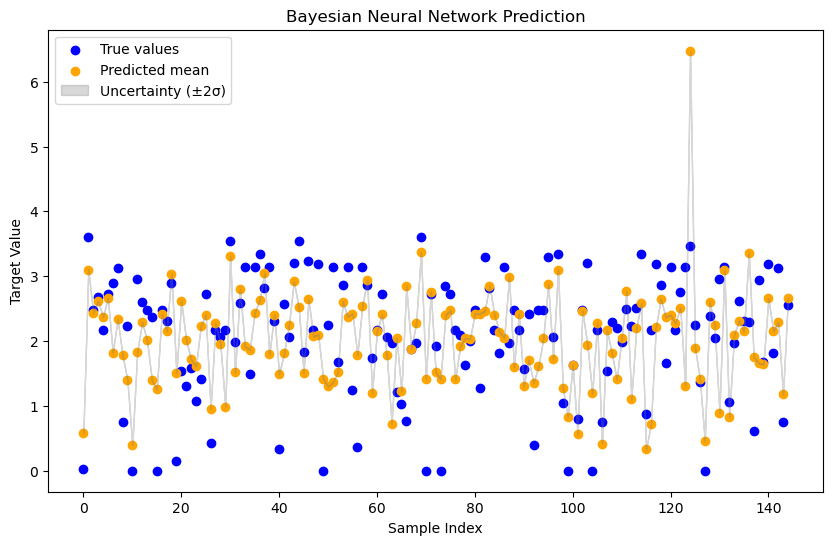

Test MAE: 0.5964, R²: 0.3124


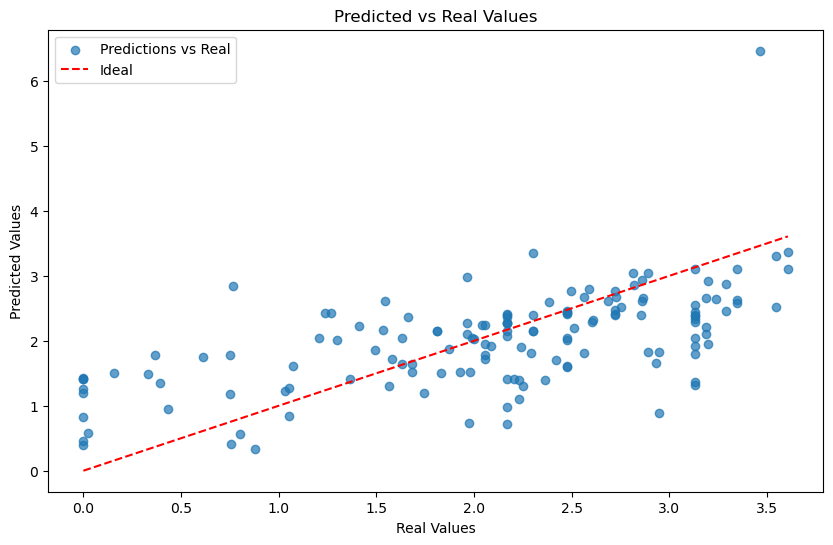

In [69]:

# Convert your data into PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ensure y has shape (N, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the Bayesian Neural Network model
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim):
        super(BayesianNN, self).__init__()
        self.blinear1 = BayesianLinear(input_dim, 64)  # First Bayesian linear layer
        self.relu = nn.ReLU()  # Activation function
        self.blinear2 = BayesianLinear(64, 1)  # Second Bayesian linear layer

    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu(x)
        x = self.blinear2(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = BayesianNN(input_dim)
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.Adam(model.parameters(), lr=0.1)  # Adam optimizer

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    output = model(X_train_tensor)  # Forward pass
    loss = criterion(output, y_train_tensor)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    preds = [model(X_test_tensor).numpy() for _ in range(100)]  # Perform multiple forward passes to sample uncertainty
    pred_mean = np.mean(preds, axis=0)  # Compute mean predictions
    pred_std = np.std(preds, axis=0)  # Compute prediction uncertainty (standard deviation)

# Evaluate model performance
mae_test = mean_absolute_error(y_test_tensor.numpy(), pred_mean)  # Calculate Mean Absolute Error
r2_test = r2_score(y_test_tensor.numpy(), pred_mean)  # Calculate R² score
print(f"Test MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# Visualize predicted vs. true values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_tensor)), y_test_tensor.numpy(), label="True values", color="blue")
plt.scatter(range(len(pred_mean)), pred_mean, label="Predicted mean", color="orange")
plt.fill_between(
    range(len(pred_mean)),
    pred_mean.flatten() - 2 * pred_std.flatten(),  # Lower bound of uncertainty
    pred_mean.flatten() + 2 * pred_std.flatten(),  # Upper bound of uncertainty
    color="gray",
    alpha=0.3,
    label="Uncertainty (±2σ)"
)
plt.legend()
plt.title("Bayesian Neural Network Prediction")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.show()

# Evaluate performance metrics again
mae_test = mean_absolute_error(y_test_tensor.numpy(), pred_mean)
r2_test = r2_score(y_test_tensor.numpy(), pred_mean)
print(f"Test MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# Visualize linear relationship between predictions and true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.numpy(), pred_mean, alpha=0.7, label="Predictions vs Real")
plt.plot([y_test_tensor.min(), y_test_tensor.max()],
         [y_test_tensor.min(), y_test_tensor.max()],
         'r--', label="Ideal")  # Red dashed line for perfect prediction
plt.title("Predicted vs Real Values")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

[I 2024-12-01 15:18:16,404] A new study created in memory with name: no-name-1fef3087-0a26-4965-b2f7-c020b01f5365
/var/folders/51/z6q40cwx17g7qh66rfnmpz380000gn/T/ipykernel_6663/1520093237.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-2)
[I 2024-12-01 15:18:19,716] Trial 0 finished with value: 0.544998049736023 and parameters: {'hidden_size': 351, 'lr': 0.009734921118919496, 'epochs': 655, 'batch_size': 96, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.544998049736023.
/var/folders/51/z6q40cwx17g7qh66rfnmpz380000gn/T/ipykernel_6663/1520093237.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest

Best parameters: {'hidden_size': 469, 'lr': 0.0007034113236017288, 'epochs': 707, 'batch_size': 85, 'optimizer': 'Adam'}
Epoch 10/707, Loss: 1.0730
Epoch 20/707, Loss: 0.9244
Epoch 30/707, Loss: 0.8645
Epoch 40/707, Loss: 0.8258
Epoch 50/707, Loss: 0.7986
Epoch 60/707, Loss: 0.7716
Epoch 70/707, Loss: 0.7503
Epoch 80/707, Loss: 0.7352
Epoch 90/707, Loss: 0.7195
Epoch 100/707, Loss: 0.7036
Epoch 110/707, Loss: 0.6928
Epoch 120/707, Loss: 0.6791
Epoch 130/707, Loss: 0.6696
Epoch 140/707, Loss: 0.6547
Epoch 150/707, Loss: 0.6429
Epoch 160/707, Loss: 0.6342
Epoch 170/707, Loss: 0.6263
Epoch 180/707, Loss: 0.6138
Epoch 190/707, Loss: 0.6060
Epoch 200/707, Loss: 0.6022
Epoch 210/707, Loss: 0.5955
Epoch 220/707, Loss: 0.5888
Epoch 230/707, Loss: 0.5782
Epoch 240/707, Loss: 0.5687
Epoch 250/707, Loss: 0.5675
Epoch 260/707, Loss: 0.5595
Epoch 270/707, Loss: 0.5521
Epoch 280/707, Loss: 0.5476
Epoch 290/707, Loss: 0.5379
Epoch 300/707, Loss: 0.5352
Epoch 310/707, Loss: 0.5313
Epoch 320/707, Loss:

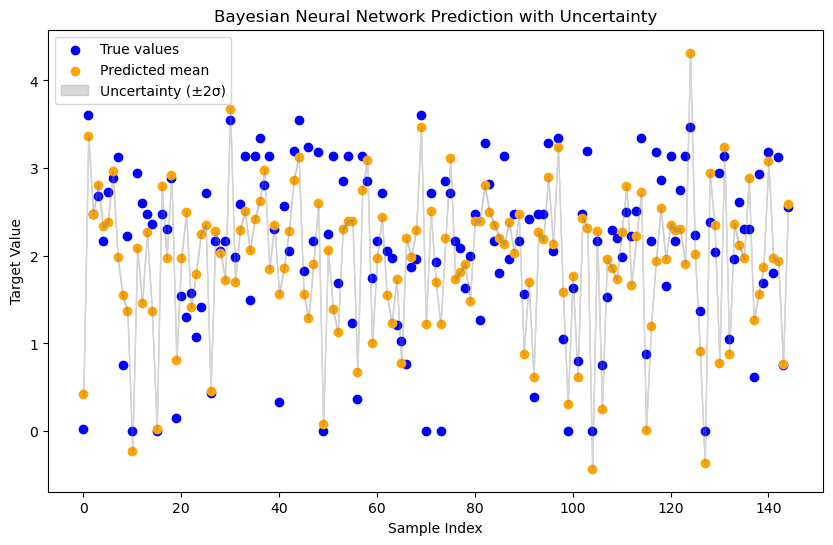

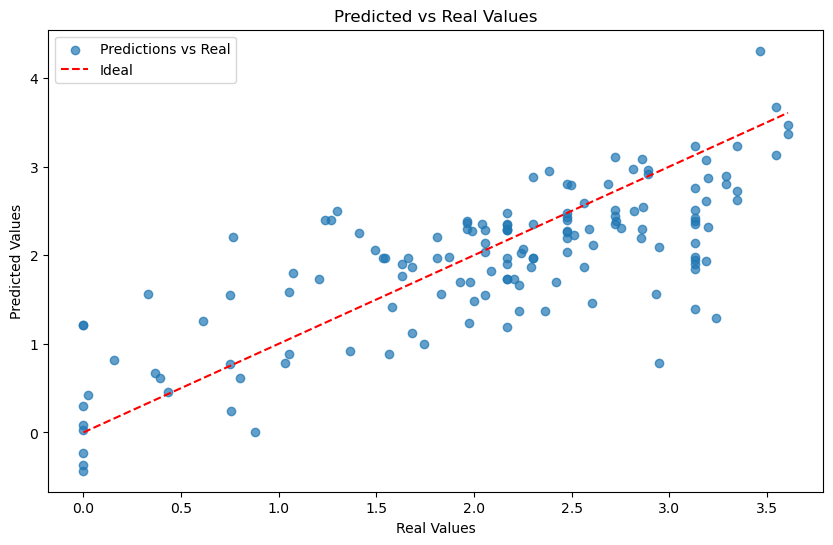

In [70]:
# Define Bayesian Neural Network model
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(BayesianNN, self).__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.blinear2 = BayesianLinear(hidden_size, 1)

    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu(x)
        x = self.blinear2(x)
        return x

# Define Optuna optimization objective
def objective(trial):
    # Expanded hyperparameter ranges
    hidden_size = trial.suggest_int("hidden_size", 32, 512)
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-2)
    epochs = trial.suggest_int("epochs", 50, 1000)
    batch_size = trial.suggest_int("batch_size", 8, 256)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    
    # Initialize model
    input_dim = X_train_tensor.shape[1]
    model = BayesianNN(input_dim, hidden_size)
    criterion = nn.MSELoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Train the model
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            optimizer.zero_grad()
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation set evaluation
    model.eval()
    with torch.no_grad():
        preds = [model(X_test_tensor).numpy() for _ in range(100)]
        pred_mean = np.mean(preds, axis=0)
        validation_loss = mean_absolute_error(y_test_tensor.numpy(), pred_mean)
    
    return validation_loss

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
best_params = study.best_trial.params
print("Best parameters:", best_params)

# Retrain the model with the best hyperparameters
hidden_size = best_params["hidden_size"]
lr = best_params["lr"]
epochs = best_params["epochs"]
batch_size = best_params["batch_size"]
optimizer_name = best_params["optimizer"]

model = BayesianNN(X_train_tensor.shape[1], hidden_size)
criterion = nn.MSELoss()
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Final training
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Test the model
model.eval()
with torch.no_grad():
    preds = [model(X_test_tensor).numpy() for _ in range(100)]
    pred_mean = np.mean(preds, axis=0)
    pred_std = np.std(preds, axis=0)

# Evaluate performance
mae_test = mean_absolute_error(y_test_tensor.numpy(), pred_mean)
r2_test = r2_score(y_test_tensor.numpy(), pred_mean)
print(f"Final Test MAE: {mae_test:.4f}, Final Test R²: {r2_test:.4f}")

# Plot 1: True vs Predicted with uncertainty on the test set
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_tensor)), y_test_tensor.numpy(), label="True values", color="blue")
plt.scatter(range(len(pred_mean)), pred_mean, label="Predicted mean", color="orange")
plt.fill_between(
    range(len(pred_mean)),
    pred_mean.flatten() - 2 * pred_std.flatten(),
    pred_mean.flatten() + 2 * pred_std.flatten(),
    color="gray",
    alpha=0.3,
    label="Uncertainty (±2σ)"
)
plt.legend()
plt.title("Bayesian Neural Network Prediction with Uncertainty")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.show()

# Plot 2: Linear relationship between predicted and true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.numpy(), pred_mean, alpha=0.7, label="Predictions vs Real")
plt.plot([y_test_tensor.min(), y_test_tensor.max()],
         [y_test_tensor.min(), y_test_tensor.max()],
         'r--', label="Ideal")
plt.title("Predicted vs Real Values")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

R² for 10% lowest uncertainty samples: 0.3560


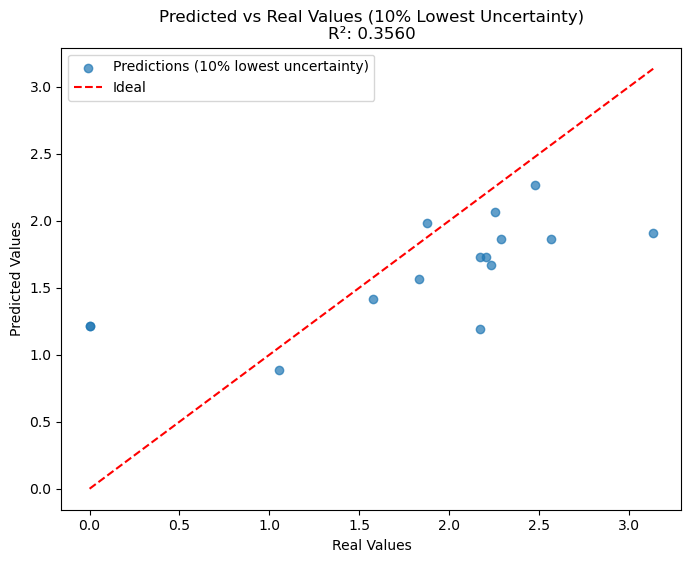

R² for 50% lowest uncertainty samples: 0.2664


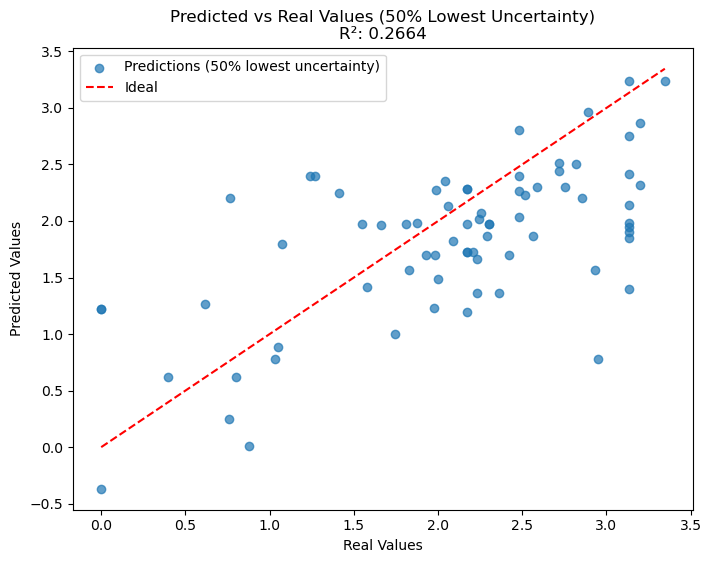

R² for 75% lowest uncertainty samples: 0.4794


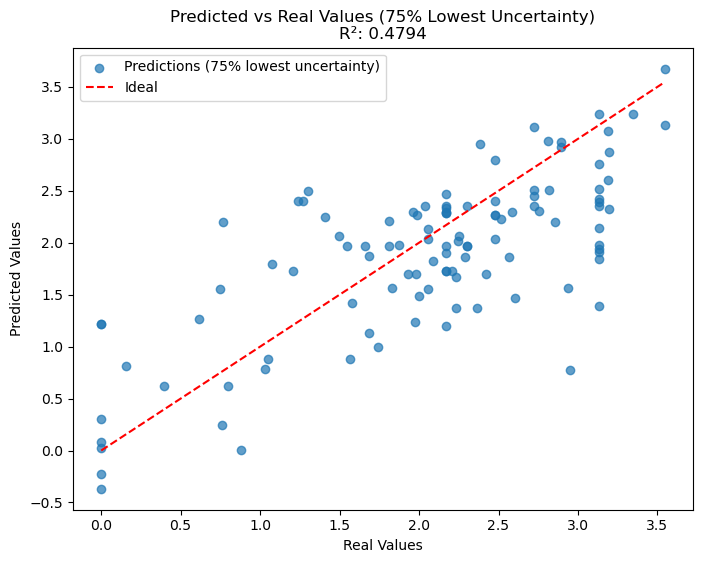

R² for 100% lowest uncertainty samples: 0.5465


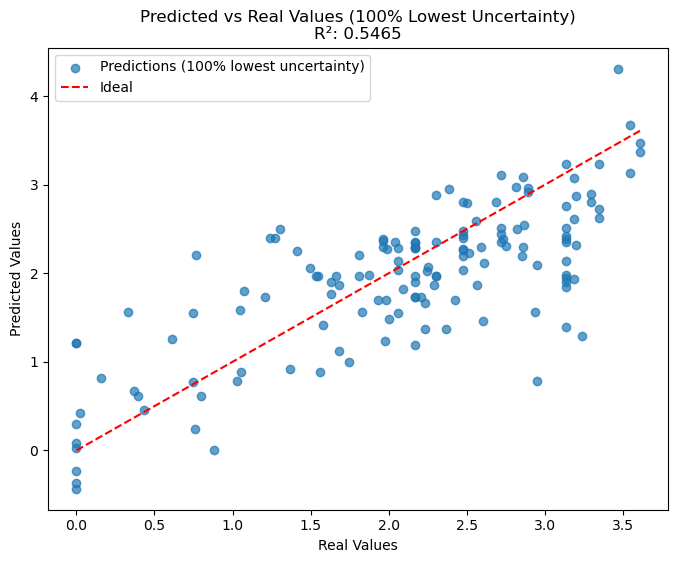

In [71]:
from sklearn.metrics import r2_score

def plot_uncertainty_vs_reality(percentile, pred_std, true_values, predicted_values, title_suffix):
    # Filter samples with uncertainty less than or equal to the given percentile
    threshold = np.percentile(pred_std, percentile)  # Get the threshold for the specified percentile
    indices = np.where(pred_std <= threshold)[0]  # Select indices of samples below the threshold

    # Get the true and predicted values for the selected samples
    true_subset = true_values[indices]
    pred_subset = predicted_values[indices]

    # Calculate R² score for the selected samples
    r2_subset = r2_score(true_subset, pred_subset)
    print(f"R² for {percentile}% lowest uncertainty samples: {r2_subset:.4f}")

    # Plot predicted vs true values
    plt.figure(figsize=(8, 6))
    plt.scatter(true_subset, pred_subset, alpha=0.7, label=f"Predictions ({percentile}% lowest uncertainty)")
    plt.plot([true_subset.min(), true_subset.max()],
             [true_subset.min(), true_subset.max()],
             'r--', label="Ideal")  # Ideal diagonal line
    plt.title(f"Predicted vs Real Values ({percentile}% Lowest Uncertainty)\nR²: {r2_subset:.4f}")
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

# Define percentiles to plot
percentiles = [10, 50, 75, 100]

# Loop through each percentile and generate plots
for percentile in percentiles:
    plot_uncertainty_vs_reality(
        percentile=percentile,
        pred_std=pred_std,
        true_values=y_test_tensor.numpy(),
        predicted_values=pred_mean,
        title_suffix=f"{percentile}% Lowest Uncertainty"
    )

[I 2024-12-01 15:56:02,983] A new study created in memory with name: no-name-c67330a8-dafd-4742-8a07-e3062efc390a


X_train_scaled shape: (1739, 25)
X_test_scaled shape: (435, 25)
NaN values removed successfully.
X_train_scaled shape after removal: (1737, 25)
y_train shape after removal: (1737,)
X_test_scaled shape after removal: (435, 25)
y_test shape after removal: (435,)


/var/folders/51/z6q40cwx17g7qh66rfnmpz380000gn/T/ipykernel_6663/1703802594.py:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-2)
[I 2024-12-01 15:56:07,546] Trial 0 finished with value: 0.8008188605308533 and parameters: {'hidden_size': 489, 'lr': 0.000113189200189731, 'epochs': 285, 'batch_size': 150, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8008188605308533.
/var/folders/51/z6q40cwx17g7qh66rfnmpz380000gn/T/ipykernel_6663/1703802594.py:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-2)
[I 2024-12-01 15:56:08,015] Trial 1 finished with value: 1.567486047744751 and par

Best parameters: {'hidden_size': 408, 'lr': 0.0012971157626150368, 'epochs': 424, 'batch_size': 129, 'optimizer': 'Adam'}
Epoch 10/424, Loss: 0.5741
Epoch 20/424, Loss: 0.5076
Epoch 30/424, Loss: 0.4731
Epoch 40/424, Loss: 0.4397
Epoch 50/424, Loss: 0.4167
Epoch 60/424, Loss: 0.3971
Epoch 70/424, Loss: 0.3831
Epoch 80/424, Loss: 0.3686
Epoch 90/424, Loss: 0.3579
Epoch 100/424, Loss: 0.3501
Epoch 110/424, Loss: 0.3403
Epoch 120/424, Loss: 0.3322
Epoch 130/424, Loss: 0.3227
Epoch 140/424, Loss: 0.3147
Epoch 150/424, Loss: 0.3074
Epoch 160/424, Loss: 0.3044
Epoch 170/424, Loss: 0.2966
Epoch 180/424, Loss: 0.2933
Epoch 190/424, Loss: 0.2866
Epoch 200/424, Loss: 0.2820
Epoch 210/424, Loss: 0.2757
Epoch 220/424, Loss: 0.2722
Epoch 230/424, Loss: 0.2644
Epoch 240/424, Loss: 0.2591
Epoch 250/424, Loss: 0.2600
Epoch 260/424, Loss: 0.2512
Epoch 270/424, Loss: 0.2514
Epoch 280/424, Loss: 0.2490
Epoch 290/424, Loss: 0.2465
Epoch 300/424, Loss: 0.2439
Epoch 310/424, Loss: 0.2401
Epoch 320/424, Loss

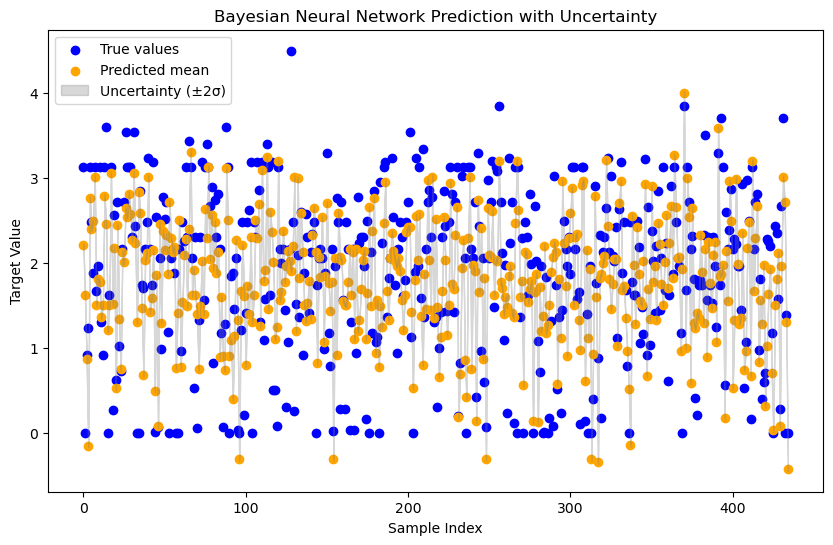

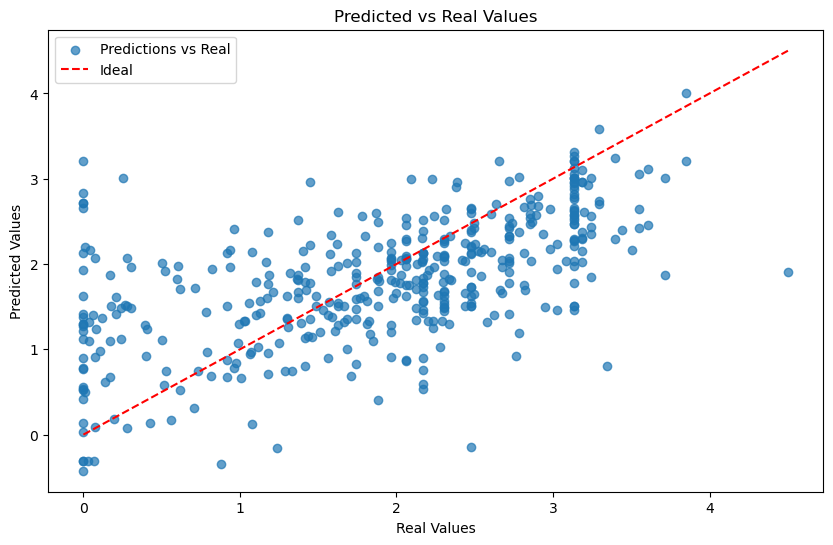

In [79]:
# Use All date to train
# Load data
df = pd.read_excel('reordered_final_merged_cleaned_qqm_molecule_charges.xlsx')

# Prepare features and target for all data (remove unnecessary columns but keep 'Q4' features)
X = df.drop(columns=['Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])  # Keep all other features
y = df['ddG']  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes of scaled data
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Remove rows with NaN values in the training set
valid_rows = ~np.isnan(X_train_scaled).any(axis=1)  # Identify rows without NaN
X_train_scaled = X_train_scaled[valid_rows]  # Keep only valid rows in features
y_train = y_train[valid_rows]  # Synchronize target variable with valid rows

# Remove rows with NaN values in the test set (in case there are any NaN)
valid_rows_test = ~np.isnan(X_test_scaled).any(axis=1)  # Identify rows without NaN
X_test_scaled = X_test_scaled[valid_rows_test]  # Keep only valid rows in features
y_test = y_test[valid_rows_test]  # Synchronize target variable with valid rows

# Verify that no NaN values remain
assert not np.isnan(X_train_scaled).any(), "NaN still present in X_train_scaled!"  # Check training features
assert not np.isnan(y_train).any(), "NaN still present in y_train!"  # Check training targets
assert not np.isnan(X_test_scaled).any(), "NaN still present in X_test_scaled!"  # Check test features
assert not np.isnan(y_test).any(), "NaN still present in y_test!"  # Check test targets

# Print success message and the new shapes of datasets
print("NaN values removed successfully.")
print(f"X_train_scaled shape after removal: {X_train_scaled.shape}")  # New shape of training features
print(f"y_train shape after removal: {y_train.shape}")  # New shape of training targets
print(f"X_test_scaled shape after removal: {X_test_scaled.shape}")  # New shape of test features
print(f"y_test shape after removal: {y_test.shape}")  # New shape of test targets

# Convert your data into PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ensure y has shape (N, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define Bayesian Neural Network model
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(BayesianNN, self).__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.blinear2 = BayesianLinear(hidden_size, 1)

    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu(x)
        x = self.blinear2(x)
        return x

# Define Optuna optimization objective
def objective(trial):
    # Expanded hyperparameter ranges
    hidden_size = trial.suggest_int("hidden_size", 32, 512)
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-2)
    epochs = trial.suggest_int("epochs", 50, 1000)
    batch_size = trial.suggest_int("batch_size", 8, 256)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    
    # Initialize model
    input_dim = X_train_tensor.shape[1]
    model = BayesianNN(input_dim, hidden_size)
    criterion = nn.MSELoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Train the model
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            optimizer.zero_grad()
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation set evaluation
    model.eval()
    with torch.no_grad():
        preds = [model(X_test_tensor).numpy() for _ in range(100)]
        pred_mean = np.mean(preds, axis=0)
        validation_loss = mean_absolute_error(y_test_tensor.numpy(), pred_mean)
    
    return validation_loss

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
best_params = study.best_trial.params
print("Best parameters:", best_params)

# Retrain the model with the best hyperparameters
hidden_size = best_params["hidden_size"]
lr = best_params["lr"]
epochs = best_params["epochs"]
batch_size = best_params["batch_size"]
optimizer_name = best_params["optimizer"]

model = BayesianNN(X_train_tensor.shape[1], hidden_size)
criterion = nn.MSELoss()
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Final training
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Test the model
model.eval()
with torch.no_grad():
    preds = [model(X_test_tensor).numpy() for _ in range(100)]
    pred_mean = np.mean(preds, axis=0)
    pred_std = np.std(preds, axis=0)

# Evaluate performance
mae_test = mean_absolute_error(y_test_tensor.numpy(), pred_mean)
r2_test = r2_score(y_test_tensor.numpy(), pred_mean)
print(f"Final Test MAE: {mae_test:.4f}, Final Test R²: {r2_test:.4f}")

# Plot 1: True vs Predicted with uncertainty on the test set
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_tensor)), y_test_tensor.numpy(), label="True values", color="blue")
plt.scatter(range(len(pred_mean)), pred_mean, label="Predicted mean", color="orange")
plt.fill_between(
    range(len(pred_mean)),
    pred_mean.flatten() - 2 * pred_std.flatten(),
    pred_mean.flatten() + 2 * pred_std.flatten(),
    color="gray",
    alpha=0.3,
    label="Uncertainty (±2σ)"
)
plt.legend()
plt.title("Bayesian Neural Network Prediction with Uncertainty")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.show()

# Plot 2: Linear relationship between predicted and true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.numpy(), pred_mean, alpha=0.7, label="Predictions vs Real")
plt.plot([y_test_tensor.min(), y_test_tensor.max()],
         [y_test_tensor.min(), y_test_tensor.max()],
         'r--', label="Ideal")
plt.title("Predicted vs Real Values")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

R² for 10% lowest uncertainty samples: 0.4812


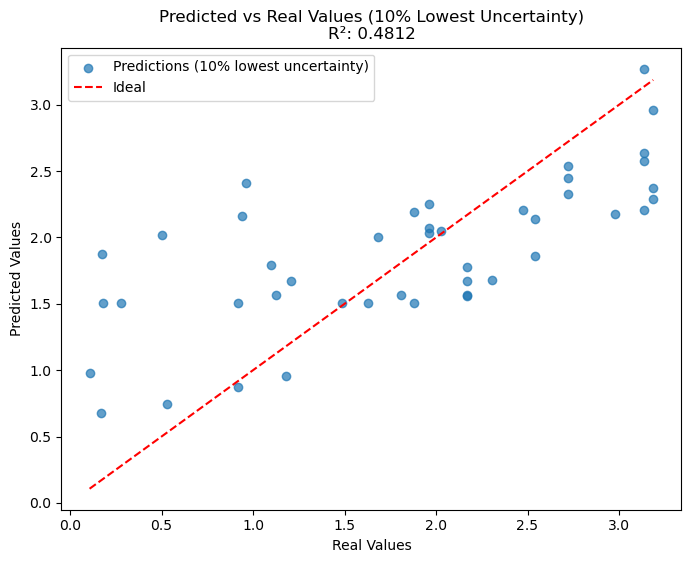

R² for 50% lowest uncertainty samples: 0.2669


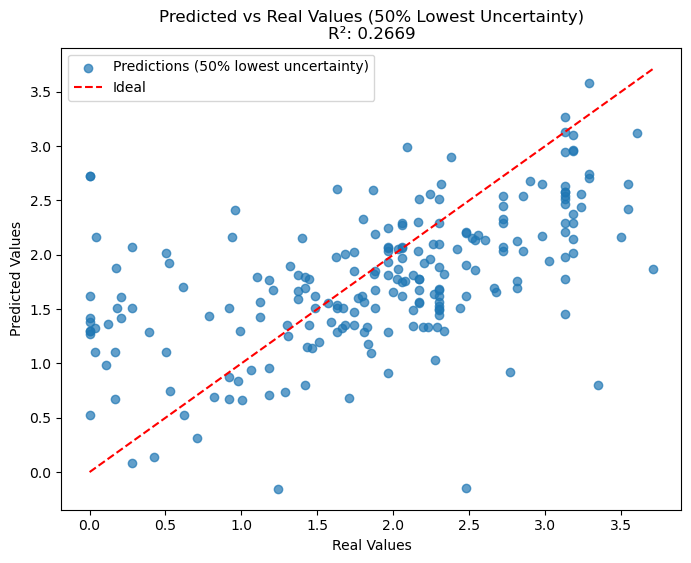

R² for 75% lowest uncertainty samples: 0.3582


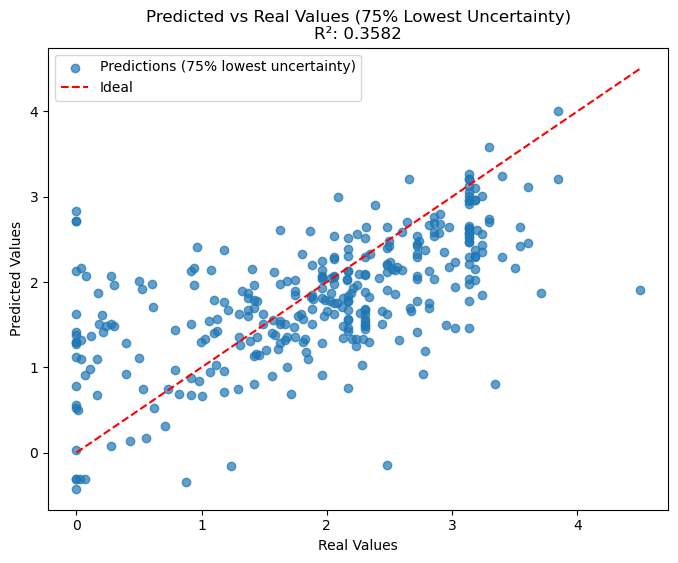

R² for 100% lowest uncertainty samples: 0.3245


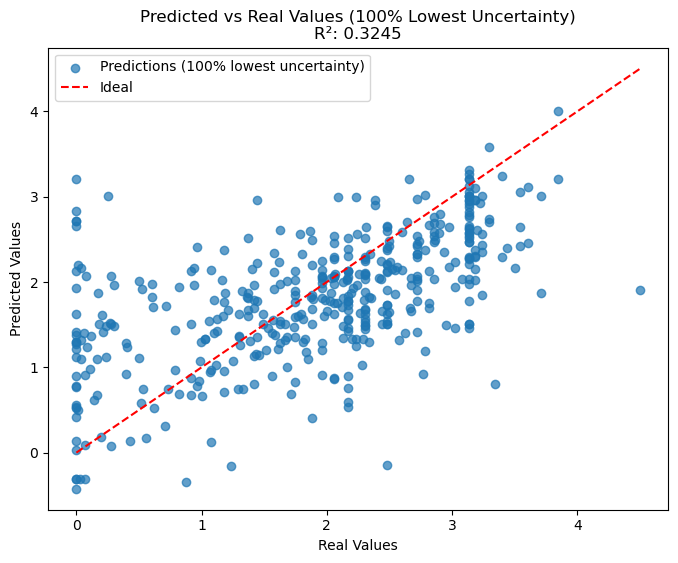

In [80]:
from sklearn.metrics import r2_score

def plot_uncertainty_vs_reality(percentile, pred_std, true_values, predicted_values, title_suffix):
    # Filter samples with uncertainty less than or equal to the given percentile
    threshold = np.percentile(pred_std, percentile)  # Get the threshold for the specified percentile
    indices = np.where(pred_std <= threshold)[0]  # Select indices of samples below the threshold

    # Get the true and predicted values for the selected samples
    true_subset = true_values[indices]
    pred_subset = predicted_values[indices]

    # Calculate R² score for the selected samples
    r2_subset = r2_score(true_subset, pred_subset)
    print(f"R² for {percentile}% lowest uncertainty samples: {r2_subset:.4f}")

    # Plot predicted vs true values
    plt.figure(figsize=(8, 6))
    plt.scatter(true_subset, pred_subset, alpha=0.7, label=f"Predictions ({percentile}% lowest uncertainty)")
    plt.plot([true_subset.min(), true_subset.max()],
             [true_subset.min(), true_subset.max()],
             'r--', label="Ideal")  # Ideal diagonal line
    plt.title(f"Predicted vs Real Values ({percentile}% Lowest Uncertainty)\nR²: {r2_subset:.4f}")
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

# Define percentiles to plot
percentiles = [10, 50, 75, 100]

# Loop through each percentile and generate plots
for percentile in percentiles:
    plot_uncertainty_vs_reality(
        percentile=percentile,
        pred_std=pred_std,
        true_values=y_test_tensor.numpy(),
        predicted_values=pred_mean,
        title_suffix=f"{percentile}% Lowest Uncertainty"
    )

In [15]:
# Use the best hyperparameter to perform
# Load data
df = pd.read_excel('reordered_final_merged_cleaned_qqm_molecule_charges.xlsx')

# Prepare features and target for all data (remove unnecessary columns but keep 'Q4' features)
X = df.drop(columns=['Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])
y = df['ddG']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Remove rows with NaN values
valid_rows = ~np.isnan(X_train_scaled).any(axis=1)
X_train_scaled = X_train_scaled[valid_rows]
y_train = y_train[valid_rows]
valid_rows_test = ~np.isnan(X_test_scaled).any(axis=1)
X_test_scaled = X_test_scaled[valid_rows_test]
y_test = y_test[valid_rows_test]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Bayesian Neural Network Model
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(BayesianNN, self).__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.blinear2 = BayesianLinear(hidden_size, 1)

    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu(x)
        x = self.blinear2(x)
        return x

# Training parameters based on your optimal results
hidden_size = 408
lr = 0.0012971157626150368
epochs = 424
batch_size = 129
optimizer_name = "Adam"

# Initialize and train the model
model = BayesianNN(X_train_tensor.shape[1], hidden_size)
criterion = nn.MSELoss()
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Training the model
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Test the model
model.eval()
with torch.no_grad():
    preds = [model(X_test_tensor).numpy() for _ in range(100)]
    pred_mean = np.mean(preds, axis=0)
    pred_std = np.std(preds, axis=0)

# Evaluate performance
mae_test = mean_absolute_error(y_test_tensor.numpy(), pred_mean)
r2_test = r2_score(y_test_tensor.numpy(), pred_mean)
print(f"Final Test MAE: {mae_test:.4f}, Final Test R²: {r2_test:.4f}")


Epoch 10/424, Loss: 0.5691
Epoch 20/424, Loss: 0.5064
Epoch 30/424, Loss: 0.4654
Epoch 40/424, Loss: 0.4357
Epoch 50/424, Loss: 0.4128
Epoch 60/424, Loss: 0.3929
Epoch 70/424, Loss: 0.3754
Epoch 80/424, Loss: 0.3635
Epoch 90/424, Loss: 0.3476
Epoch 100/424, Loss: 0.3360
Epoch 110/424, Loss: 0.3269
Epoch 120/424, Loss: 0.3187
Epoch 130/424, Loss: 0.3126
Epoch 140/424, Loss: 0.3062
Epoch 150/424, Loss: 0.3009
Epoch 160/424, Loss: 0.2933
Epoch 170/424, Loss: 0.2893
Epoch 180/424, Loss: 0.2821
Epoch 190/424, Loss: 0.2801
Epoch 200/424, Loss: 0.2737
Epoch 210/424, Loss: 0.2655
Epoch 220/424, Loss: 0.2624
Epoch 230/424, Loss: 0.2603
Epoch 240/424, Loss: 0.2556
Epoch 250/424, Loss: 0.2478
Epoch 260/424, Loss: 0.2416
Epoch 270/424, Loss: 0.2372
Epoch 280/424, Loss: 0.2344
Epoch 290/424, Loss: 0.2288
Epoch 300/424, Loss: 0.2214
Epoch 310/424, Loss: 0.2243
Epoch 320/424, Loss: 0.2243
Epoch 330/424, Loss: 0.2119
Epoch 340/424, Loss: 0.2112
Epoch 350/424, Loss: 0.2113
Epoch 360/424, Loss: 0.2085
E

In [16]:
# SHAP Analysis Function
def compute_shap_values(model, X_tensor, feature_names):
    model.eval()

    def bnn_predict(x_numpy):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
        with torch.no_grad():
            preds = [model(x_tensor).numpy() for _ in range(100)]
        return np.mean(preds, axis=0)

    X_numpy = X_tensor.numpy()
    explainer = shap.KernelExplainer(bnn_predict, X_numpy)
    shap_values = explainer.shap_values(X_numpy, nsamples=100)
    
    np.save("shap_values.npy", shap_values)
    np.save("shap_expected_value.npy", explainer.expected_value)
    return shap_values, explainer.expected_value

shap_values, expected_value = compute_shap_values(model, X_test_tensor, feature_names)

Using 435 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/435 [00:00<?, ?it/s]

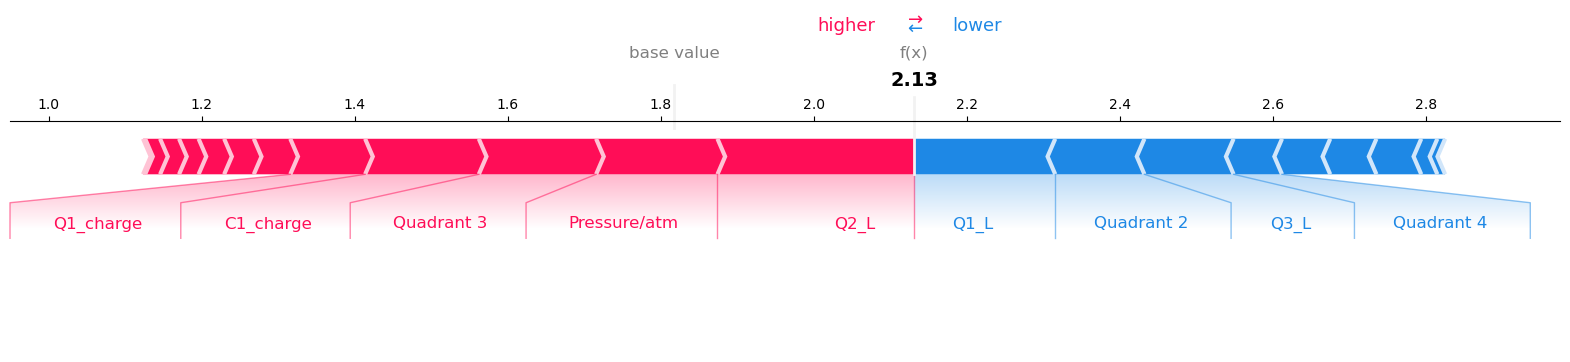

In [17]:
# Reduce dimensions of shap_values
shap_values_reshaped = shap_values.squeeze(axis=2)  # Remove the third dimension

# Generate summary plot
shap.summary_plot(shap_values_reshaped, X_test_tensor.numpy(), feature_names=feature_names, show=False)

# Save the summary plot as an image
plt.savefig("shap_summary_plot_fixed.png")
plt.close()

# Generate a force plot for a single sample
sample_index = 0  # Select the index of the sample
shap.force_plot(
    expected_value,  # Expected value from SHAP analysis
    shap_values_reshaped[sample_index],  # SHAP values for the selected sample
    feature_names=feature_names,  # List of feature names
    matplotlib=True  # Use matplotlib for visualization
)

# Save the force plot as an image
plt.savefig("shap_force_plot_fixed.png")
plt.close()